# 2. Regression

packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

importation des données

In [2]:
PATH = 'data/'
DATA = 'auto-mpg.csv'
HEADER = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name']
feature_name = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name']
target_name = 'mpg'

séparation des données, pour avoir les features et la classe target

In [3]:
dataset = pd.read_csv(PATH+DATA, sep=',', na_values='?', header=None, names=HEADER)
X = dataset[feature_name]
y = dataset[target_name]

## Arbre de régression

### Préparation des données

Modèle d'arbre de régression  
Entrainement du modèle

- Traitement données manquantes
la colonne 'horsepower' possède des données manquantes, il s'agit d'une colonne numérique, la colonne prend de nombreuses valeurs, on choisit de remplacer les données manquantes par la moyenne (`SimpleImputer`)
- Colonnes `car name`
On choisit de retirer la colonne car name car elle contient trop d'échantillon unique. Cette attribut est donc non pertinent pour la régression.
- Pas de traitement
On peut preciser à la pipeline de ne pas traiter certaines colonnes (`FunctionTransformer`, sans paramètre il s'agit de la fonction identité)

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.tree import DecisionTreeRegressor

same_columns = ['cylinders', 'displacement', 'weight', 'acceleration', 'model year', 'origin']
drop_columns = ['car name']
imput_columns = ['horsepower']

X = X.drop(columns=drop_columns)
feature_name = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']

identity = FunctionTransformer()
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
preprocesser = ColumnTransformer([('identity', identity, same_columns), ('imputer', imputer, imput_columns)])

tree = DecisionTreeRegressor()

model = make_pipeline(preprocesser, tree)

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('identity',
                                                  FunctionTransformer(),
                                                  ['cylinders', 'displacement',
                                                   'weight', 'acceleration',
                                                   'model year', 'origin']),
                                                 ('imputer', SimpleImputer(),
                                                  ['horsepower'])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [5]:
model.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('identity',
                                                  FunctionTransformer(),
                                                  ['cylinders', 'displacement',
                                                   'weight', 'acceleration',
                                                   'model year', 'origin']),
                                                 ('imputer', SimpleImputer(),
                                                  ['horsepower'])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

## Visualisation de l'arbre

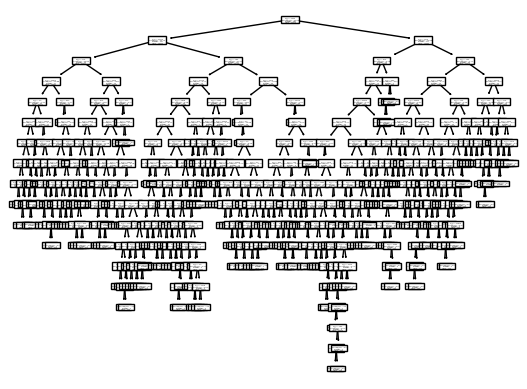

In [6]:
from sklearn import tree

model_tree = model['decisiontreeregressor']
tree.plot_tree(model_tree)
plt.show()

## Importances des attributs

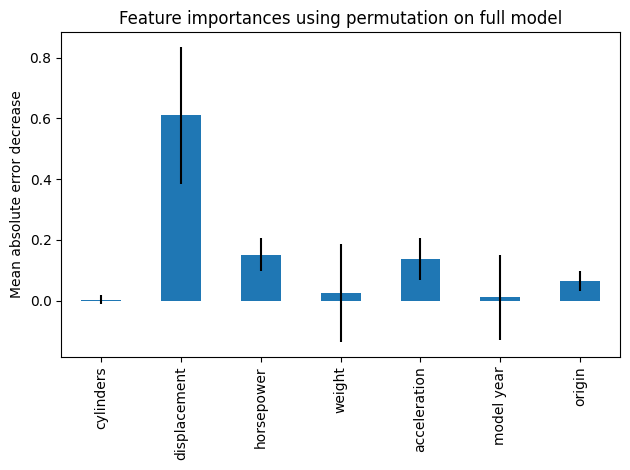

In [7]:
from sklearn.inspection import permutation_importance

feature_importance = model_tree.feature_importances_

feature_importance_dataframe = pd.Series(feature_importance, index=feature_name)

result = permutation_importance(
    model, X, y, n_repeats=10, random_state=42, n_jobs=2, scoring='neg_mean_absolute_error'
)

fig, ax = plt.subplots()
feature_importance_dataframe.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean absolute error decrease")
fig.tight_layout()
plt.show()

L'attribut `displacement` est la plus importante car une permutation sur cette attribut peut réduire l'erreur absolue de 0.6 mpg en moyenne.  
Les attributs `weight` ou `model year` affecte moins le modèle, le mélange peut augmenter comme réduire l'erreur.  

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

y_predicted = model.predict(X)

mean_absolute_error = mean_absolute_error(y, y_predicted)
print(f"Mean absolute error : {mean_absolute_error:.2f}")

mean_squared_error = mean_squared_error(y, y_predicted)
print(f"Mean squared error : {mean_squared_error:.2f}")

r2_score = r2_score(y, y_predicted)
print(f"R^2 : {r2_score:.2f}")

Mean absolute error : 0.00
Mean squared error : 0.00
R^2 : 1.00


Les résultats sont parfaits puisque l'arbre c'est entraîné sur toutes les données sans conditions d'arrêt (max profondeur par exemple)

## Test validation croisée (10 Folds)

In [9]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, X, y, cv=10, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'])

mean_squared_error = -cv_results['test_neg_mean_squared_error']
mean_absolute_error = -cv_results['test_neg_mean_absolute_error']
r2 = cv_results['test_r2']

print("The mean cross-validation squared error is: "
      f"{mean_squared_error.mean():.3f} ± {mean_squared_error.std():.3f} mpg")

print("The mean cross-validation absolute error is: "
      f"{mean_absolute_error.mean():.3f} ± {mean_absolute_error.std():.3f} mpg")

print(f"Les valeurs vont de {min(y)} à {max(y)} mpg, la moyenne est de {y.mean():.3f} mpg")

print("The mean cross-validation r2 is: "
      f"{r2.mean():.3f} ± {r2.std():.3f} mpg")

The mean cross-validation squared error is: 15.020 ± 8.628 mpg
The mean cross-validation absolute error is: 2.826 ± 0.788 mpg
Les valeurs vont de 9.0 à 46.6 mpg, la moyenne est de 23.515 mpg
The mean cross-validation r2 is: 0.581 ± 0.240 mpg


L'erreur absolue est environ entre 2 et 3 mpg en moyenne sur les 10 validations croisées.  
L'erreur aux carré est de 15 à 16.  
Le $r^2$ moyen est entre 0.5 et 0.6, ce qui est plutot faible, les valeurs de test et les valeurs prédites ne semble pas linéairement dépendant.

## Forêt aléatoire

On teste sur l'erreur absolue moyenne sur une validation croisée à 10 folds.

On fait varier la profondeur maximale :
max_depth [10, 50, 100, 150, 200, 250]

On fait varier le nombre d'arbres :
n_estimators [1, 2, 5, 50, 100, 200, 500, 1000]

In [10]:
# On traite les données manquantes pour ne pas avoir à le faire à chaque fois

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

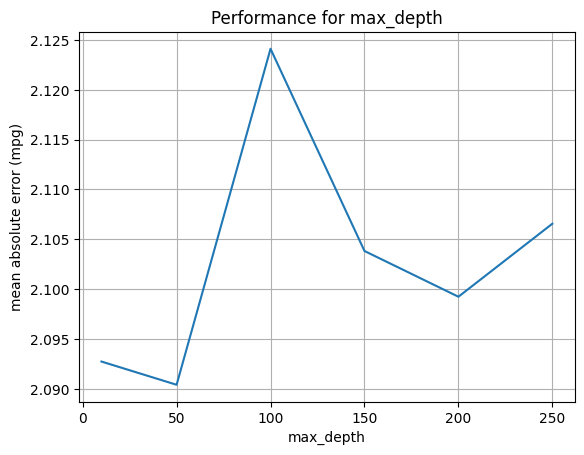

In [11]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = [10, 50, 100, 150, 200, 250]

mean_squared_error = []
mean_absolute_error = []
r2 = []

for max_depth in max_depth_list:
    model = RandomForestRegressor(max_depth=max_depth)

    cv_results = cross_validate(model, X_imputed, y, cv=10, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'])

    mean_squared_error_test = -cv_results['test_neg_mean_squared_error']
    mean_absolute_error_test = -cv_results['test_neg_mean_absolute_error']
    r2_test = cv_results['test_r2']

    mean_squared_error.append(mean_squared_error_test.mean())
    mean_absolute_error.append(mean_absolute_error_test.mean())
    r2.append(r2_test.mean())

plt.clf()
plt.plot(max_depth_list, mean_absolute_error)
plt.title('Performance for max_depth')
plt.xlabel('max_depth')
plt.ylabel('mean absolute error (mpg)')
plt.grid()
plt.show() 

La fôret aléatoire est plus performante que l'arbre de regression.  
Dans ce cas, les erreurs sont proches de 2 mpg, la courbe change énormement lorsqu'on relance les validations croisées. Cependant les valeurs sont toutes très proches et reste autour de 2.1 mpg.  
Le paramètres max_depth ne change pas beaucoup les performances du modèle.

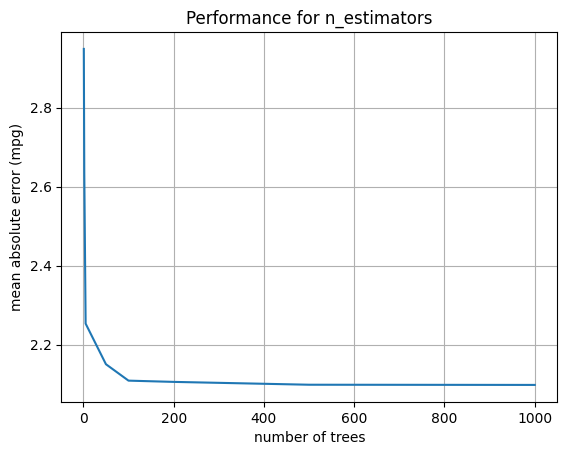

In [12]:
n_estimators_list = [1, 2, 5, 50, 100, 200, 500, 1000]

mean_squared_error = []
mean_absolute_error = []
r2 = []

for n_estimators in n_estimators_list:
    model = RandomForestRegressor(n_estimators=n_estimators)

    cv_results = cross_validate(model, X_imputed, y, cv=10, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'])

    mean_squared_error_test = -cv_results['test_neg_mean_squared_error']
    mean_absolute_error_test = -cv_results['test_neg_mean_absolute_error']
    r2_test = cv_results['test_r2']

    mean_squared_error.append(mean_squared_error_test.mean())
    mean_absolute_error.append(mean_absolute_error_test.mean())
    r2.append(r2_test.mean())

plt.clf()
plt.plot(n_estimators_list, mean_absolute_error)
plt.title('Performance for n_estimators')
plt.xlabel('number of trees')
plt.ylabel('mean absolute error (mpg)')
plt.grid()
plt.show() 

On voit que l'erreur est autour de 3 mpg pour peu d'arbre, à partir de 100 arbres, l'erreur est constante vers 2.1 mpg.
On choisit de continuer avec 100 arbres pour simplifier le modèle est avoir environ les mêmes performances.

## Conclusion

L'étude à consister à traiter les attributs, retirer les attributs non pertinents, ajouter des valeurs moyennes.  

Le modèle d'arbre de décision donne une erreur absolue d'environ 2.7 à 3 mpg, les valeurs variant de 9 à 47 cela semble assez satisfaisant.  
Il est tout de même possible d'avoir de meilleurs performances avec des fôrets aléatoires.

Pour la suite, d'autres modèles de régression peuvent être envisagés. On peut aussi jouer sur plus de données et plus de paramètres.